In [1]:
# Se si esegue in locale, assicurarsi di avere git installato
# Al link della repository sono visionabili tutti i file
from os import path
if not path.exists("Laboratorio_Fisica_3"):
    !git clone https://github.com/MasterRoby3/Laboratorio_Fisica_3

# Per comodità si definisce una variabile che sia la radice di tutti i percorsi utilizzati, in modo da alleggerire il codice successivo
rad = "Laboratorio_Fisica_3/Fotodiodo_frequenza/"

# In questa prima cella si importano anche le librerie necessarie:
import numpy as np
from scipy import optimize as sop
from scipy import constants as scc
import matplotlib.pyplot as plt
import pandas as pd

# Si memorizzano anche alcune costanti utili più avanti
electron_charge = scc.e
Boltzmann = scc.Boltzmann
temperature = 300

#Altri dati utili per i plot
titlefontsize, labelfontsize, tickfontsize=20, 16, 14
markersize, linewidth = 6, 1

# Accoppiamento LED-PD in funzione della frequenza di modulazione

#### Struttura dell'esperimento

In questo esperimento si vuole verificare l'andamento del segnale rilevato da un fotodiodo accoppiato ad un LED in funzione della frequenza dell'onda quadra con cui si accende/spegne il led.

Per fare ciò si utilizza un generatore di funzioni a cui è collegato direttamente il LED tramite la presa con i morsetti, per non interferire con i contatti sulla basetta. Lo schema circuitale è il seguente:

<br><center><img src="Laboratorio_Fisica_3/Fotodiodo_frequenza/img/pd-frequenza.png"/></center><br>

Per accoppiare nel modo migliore possibile LED e fotodiodo si sono utilizzati dei tubicini appositi. La tensione picco-picco utilizzata è stata di 5-6 V e si sono raccolti dati a varie frequenze con varie resistenze R. La tensione ai capi di R si è misurata con un oscilloscopio.

NOTA: in questa esperienza non si utilizza una resistenza di protezione per il LED dato che sul periodo si trasferisce poca potenza.

### Funzione di fit per la risposta del fotodiodo in funzione della frequenza
In questo tipo di circuito la potenza varia al variare della frequenza con un'andamento del tipo: $\frac{1}{1+\omega^2/\omega_0^2}$. In quest'esperienza, però, sono stati rilevati segnali in tensione tramite l'oscilloscopio. Quindi la funzione su cui poi si andrà a fare il fit è la seguente:
$$V(\omega))=\frac{V_0}{\sqrt{(1+\omega^2/\omega_0^2)}}$$
dove si effettua quindi un fit a due parametri, $I_0$ e $\omega_0$

Quando si alimenta in onda quadra, però, la risposta segue più un andamento del tipo:
$$V = V_0 \tanh \left(\frac{\pi}{2}\frac{\omega_0}{\omega}\right)$$

In fase di fit si proveranno a fittare i dati con entrambe le funzioni, paragonando i risultati. Nelle celle di seguito si procede direttamente a raccogliere i dati e effettuare i fit.

In [7]:
def segnale_v(omega, omega0, V0):
    V=V0/np.sqrt(1+omega**2/omega0**2)
    return V

def segnale_mod(omega, omega0, V0):
    V = V0 * np.tanh( (np.pi * omega0) / (2 * omega))
    return V

# Funzione utile per il calcolo dell'R^2
def r_squared(actual, predicted):
    residuals = actual - predicted
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum( (actual - np.mean(actual))**2 )
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [9]:
# memorizzazione dei dati dai file
filenames = ["R500_data.csv", "R1k_data.csv", "R5k_data.csv", "R10k_data.csv"]
Rs = [500, 1000, 5000, 10000]

data = []
for filename in filenames:
    data.append(pd.read_csv(rad+"data/"+filename))

omegas = []
Vs = []

for index, df in enumerate(data):
    R = Rs[index]
    headers=df.keys()
    # La pulsazione va ricavata convertendo dalla frequenza presente su file
    omega=df['f'].to_numpy() * 2 * np.pi
    # La tensione memorizzata è in millivolt
    V = df['V'].to_numpy()

    omegas.append(omega)
    Vs.append(V)

In [60]:
# Fit e salvataggio parametri fittati
# Nelle liste con _classic si salvano i dati fittati con la prima equazione, in _tanh quelli fittati con la seconda
omega0_fit_classic = []
omega0_fit_tanh = []
V0_fit_classic = []
V0_fit_tanh = []
r_sq_fit_classic = []
r_sq_fit_tanh = []

for index in range(len(omegas)):
    omega = omegas[index]
    V = Vs[index]
    R = Rs[index]
    ndata=len(V)
    min=[1e2,  0]   # minimum values for omega0, I0
    max=[1e8, 500]  # maximum values for omega0, I0
    bounds=(min,max) # bounds on the fitting parameters

    # fit _classic
    popt, pcov=sop.curve_fit(segnale_v, omega, V, bounds=bounds)
    omega0_fit = popt[0]   # questo è il valore di omega0 che risulta dal fit
    V0_fit     = popt[1]   # questo è il valore di V0 che risulta dal fit
    sigma = np.sqrt(ndata*np.diag(pcov))
    r_sq = r_squared(V, segnale_v(omega, omega0_fit, V0_fit))
    omega0_fit_classic.append([omega0_fit, sigma[0]])
    V0_fit_classic.append([V0_fit, sigma[1]])
    r_sq_fit_classic.append(r_sq)

    # fit _tanh
    popt, pcov=sop.curve_fit(segnale_mod, omega, V, bounds=bounds)
    omega0_fit = popt[0]   # questo è il valore di omega0 che risulta dal fit
    V0_fit     = popt[1]   # questo è il valore di V0 che risulta dal fit
    sigma = np.sqrt(ndata*np.diag(pcov))
    r_sq = r_squared(V, segnale_mod(omega, omega0_fit, V0_fit))
    omega0_fit_tanh.append([omega0_fit, sigma[0]])
    V0_fit_tanh.append([V0_fit, sigma[1]])
    r_sq_fit_tanh.append(r_sq)

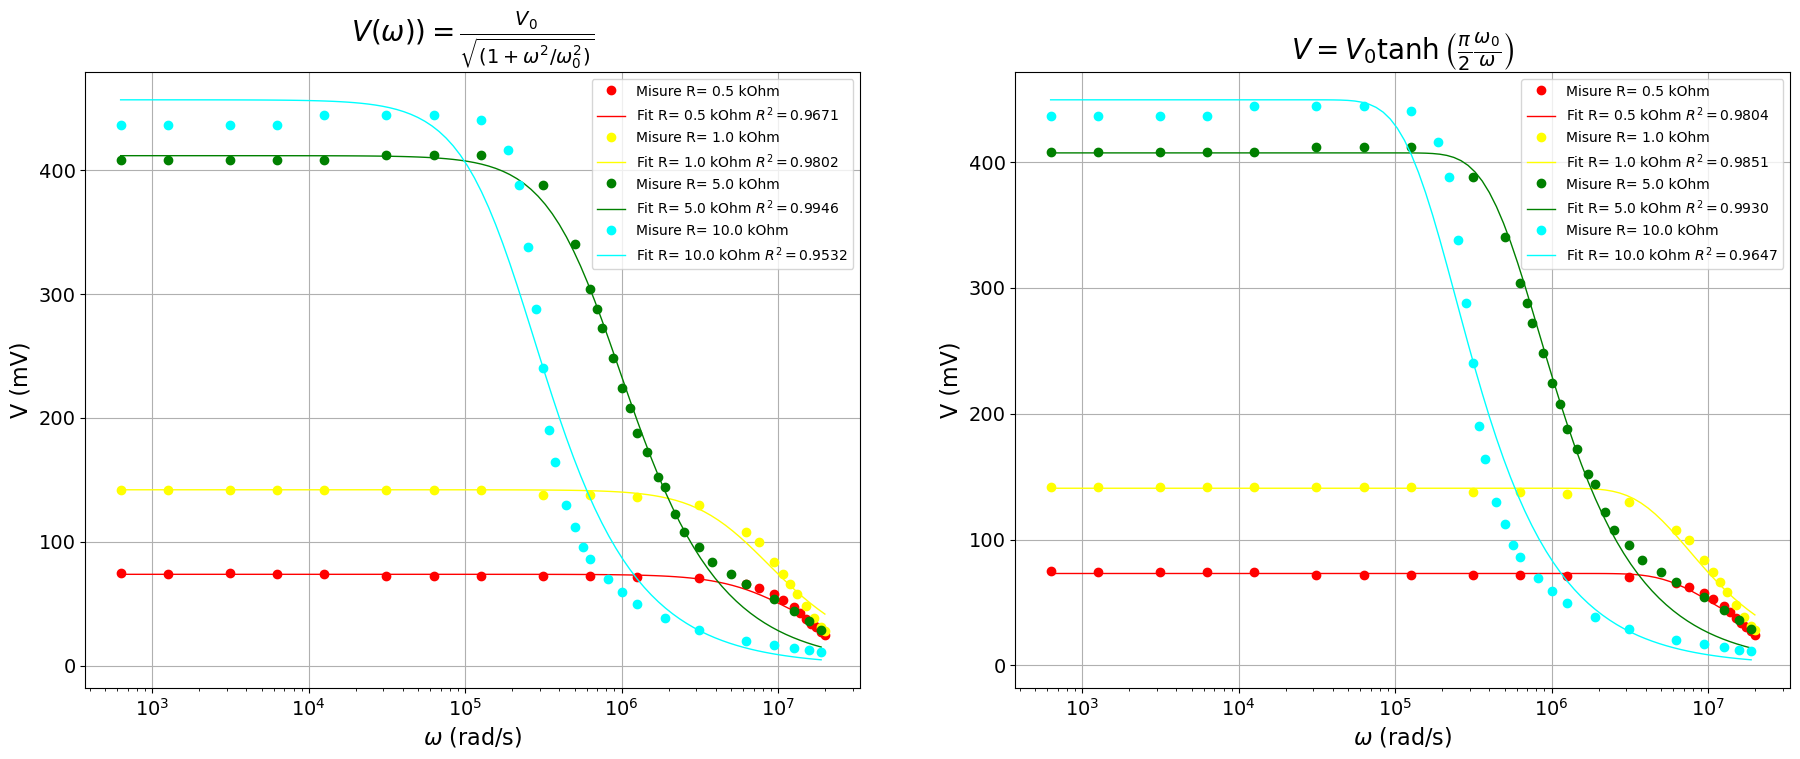

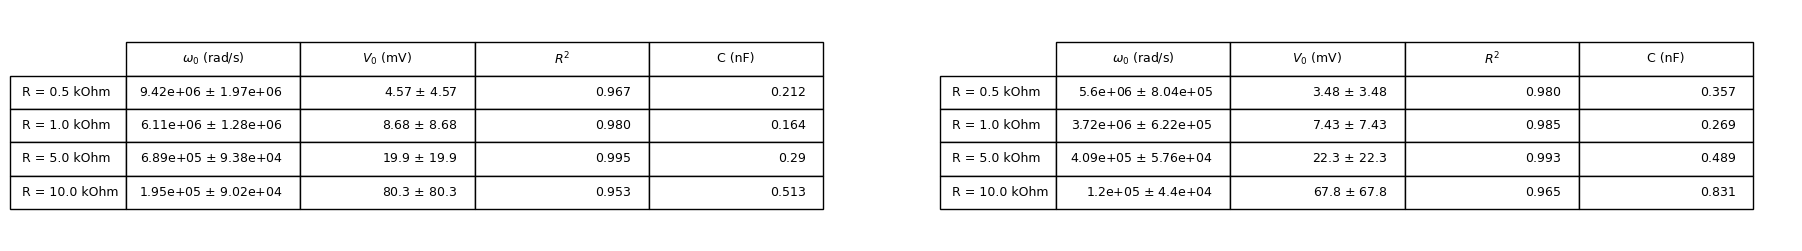

In [61]:
# Plots
# array di colori per plottare rapidamente
colors = ["red", "yellow", "green", "cyan"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[22,8])

ax1.set_title(r'$V(\omega))=\frac{V_0}{\sqrt{(1+\omega^2/\omega_0^2)}}$', size=titlefontsize)
for index, v_curr in enumerate(Vs):
    ax1.plot(omegas[index], v_curr, 'o', markersize=markersize, color=colors[index], label="Misure R= "+str(Rs[index]/1000)+" kOhm")
    ndata = len(omegas[index])
    xmin,xmax=omegas[index][0],omegas[index][ndata-1]
    xfit=np.logspace(np.log10(xmin),np.log10(xmax),100)
    yfit=segnale_v(xfit,omega0_fit_classic[index][0],V0_fit_classic[index][0])
    ax1.plot(xfit, yfit, linewidth=linewidth, color=colors[index], label="Fit R= "+str(Rs[index]/1000)+" kOhm $R^2=${:.4f}".format(r_sq_fit_classic[index]))

ax1.set_xscale("log")
ax1.set_xlabel('$\omega$ (rad/s)', size=labelfontsize)
ax1.set_ylabel('V (mV)', size=labelfontsize)
ax1.tick_params(labelsize=tickfontsize)
ax1.grid(True)
ax1.legend(loc="upper right")

ax2.set_title(r'$V = V_0 \tanh \left(\frac{\pi}{2}\frac{\omega_0}{\omega}\right)$', size=titlefontsize)
for index, v_curr in enumerate(Vs):
    ax2.plot(omegas[index], v_curr, 'o', markersize=markersize, color=colors[index], label="Misure R= "+str(Rs[index]/1000)+" kOhm")
    ndata = len(omegas[index])
    xmin,xmax=omegas[index][0],omegas[index][ndata-1]
    xfit=np.logspace(np.log10(xmin),np.log10(xmax),100)
    yfit=segnale_mod(xfit,omega0_fit_tanh[index][0],V0_fit_tanh[index][0])
    ax2.plot(xfit, yfit, linewidth=linewidth, color=colors[index], label="Fit R= "+str(Rs[index]/1000)+" kOhm $R^2=${:.4f}".format(r_sq_fit_tanh[index]))

ax2.set_xscale("log")
ax2.set_xlabel('$\omega$ (rad/s)', size=labelfontsize)
ax2.set_ylabel('V (mV)', size=labelfontsize)
ax2.tick_params(labelsize=tickfontsize)
ax2.grid(True)
ax2.legend(loc="upper right")

fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=[22,3])

ax3.axis('tight')
ax3.axis('off')
rows = ["R = "+str(r/1000)+" kOhm" for r in Rs]
cols = [r"$\omega_0$ (rad/s)", "$V_0$ (mV)", "$R^2$", "C (nF)"]
table_data = [
    ["{:.3g}".format(arr[0]) + r" $\pm$ " + "{:.3g}".format(arr[1]) for arr in omega0_fit_classic],
    ["{:.3g}".format(arr[1]) + r" $\pm$ " + "{:.3g}".format(arr[1]) for arr in V0_fit_classic],
    ["{:.3f}".format(arr) for arr in r_sq_fit_classic],
    ["{:.3g}".format(1/(arr[0]*Rs[ind]) * 1e9) for ind, arr in enumerate(omega0_fit_classic)],
]
table = ax3.table(cellText=pd.DataFrame(table_data).T.values, rowLabels=rows, colLabels=cols, loc='center')
table.set_fontsize(14)
table.scale(0.9, 2)

ax4.axis('tight')
ax4.axis('off')
rows = ["R = "+str(r/1000)+" kOhm" for r in Rs]
cols = [r"$\omega_0$ (rad/s)", "$V_0$ (mV)", "$R^2$", "C (nF)"]
table_data = [
    ["{:.3g}".format(arr[0]) + r" $\pm$ " + "{:.3g}".format(arr[1]) for arr in omega0_fit_tanh],
    ["{:.3g}".format(arr[1]) + r" $\pm$ " + "{:.3g}".format(arr[1]) for arr in V0_fit_tanh],
    ["{:.3f}".format(arr) for arr in r_sq_fit_tanh],
    ["{:.3g}".format(1/(arr[0]*Rs[ind])  * 1e9) for ind, arr in enumerate(omega0_fit_tanh)],
]
table = ax4.table(cellText=pd.DataFrame(table_data).T.values, rowLabels=rows, colLabels=cols, loc='center')
table.set_fontsize(14)
table.scale(0.9, 2)

Sui risultati ottenuti si può fare una considerazione interessante: nonostante l'andamento sia simile, a seconda della funzione di fit i variabili possono variare anche notevolmente, portando a discrepanze anche di un fattore 2 nella stima della capacità. Nel complesso, però, i fit sono più che adeguati

### Senza resistenza
Nel caso in cui non si colleghi nessuna resistenza, ma si lasci il circuito aperto collegato ai capi dell'oscilloscopio, la resistenza divenda di fatto la resistenza dell'oscilloscopio (1MOhm). Nella cella seguente si svolge un solo fit con la funzione
$$V(\omega))=\frac{V_0}{\sqrt{(1+\omega^2/\omega_0^2)}}$$ per esplorare questa casistica.

Valore fittato per la frequenza di taglio: omega0_fit=8.155e+04, deviazione standard=2.128e+04
Valore fittato per intensità V0          :     V0_fit=234.6,     deviazione standard=24.81
La capacità per 1 MOhm di resistenza (quella dell'oscilloscopio): 1.2262e-11
R^2: 0.98501





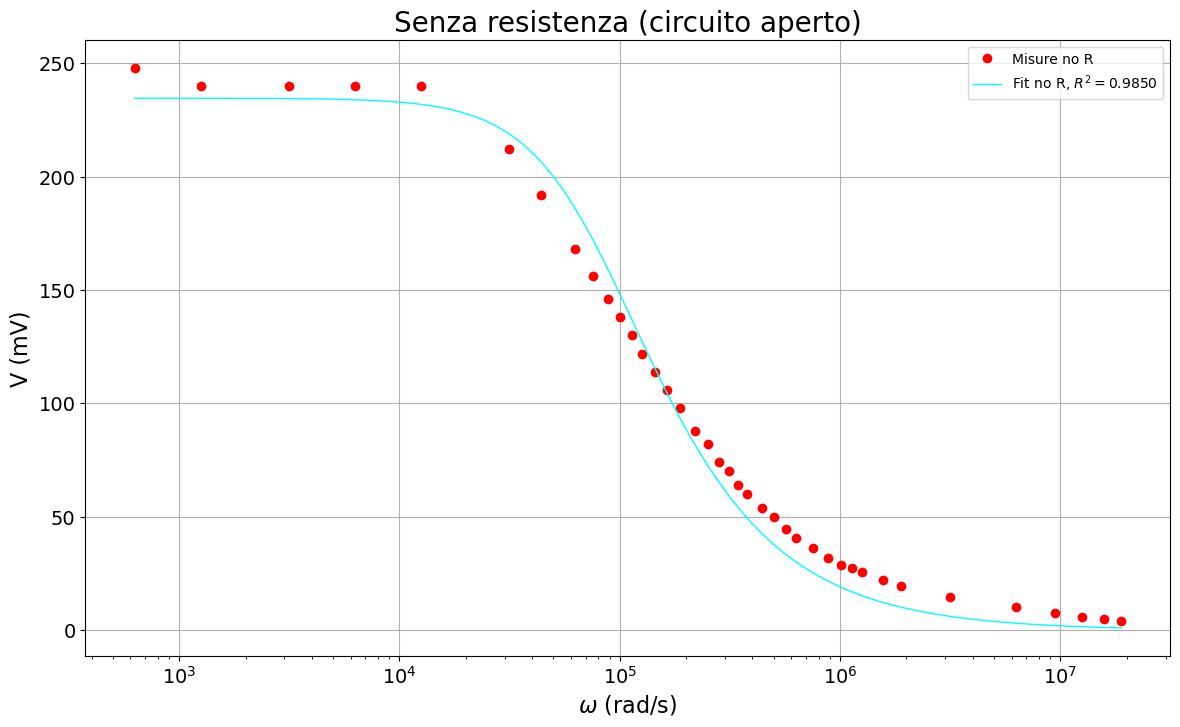

In [59]:
df = pd.read_csv(rad+"data/NoR_data.csv")
headers=df.keys()

omega=df['f'].to_numpy() * 2 * np.pi
V=df['V'].to_numpy()    # in mV

ndata=len(V)
min=[1e2,  0]   # minimum values for omega0, V0
max=[1e8, 700]  # maximum values for omega0, V0
bounds=(min,max) # bounds on the fitting parameters
popt, pcov=sop.curve_fit(segnale_v, omega, V)
omega0_fit = popt[0]   # questo è il valore di omega0 che risulta dal fit
V0_fit     = popt[1]   # questo è il valore di I0 che risulta dal fit
sigma = np.sqrt(ndata*np.diag(pcov))

r_sq = r_squared(V, segnale_v(omega, omega0_fit, V0_fit))

# questo è un formato di scrittura più elaborato, che permette di formattare i valori...
print(f"Valore fittato per la frequenza di taglio: omega0_fit={omega0_fit:.4g}, deviazione standard={sigma[0]:.4g}")
print(f"Valore fittato per intensità V0          :     V0_fit={V0_fit:.4g},     deviazione standard={sigma[1]:.4g}")

R_oscill = 1000000
print("La capacità per 1 MOhm di resistenza (quella dell'oscilloscopio): {:.5g}".format(1/(omega0_fit * R_oscill)))
print("R^2: {:.5g}".format(r_sq))
print("\n\n")

fig, ax = plt.subplots(1, 1, figsize=[14,8])

ax.set_title('Senza resistenza (circuito aperto)', size=titlefontsize)

ax.plot(omega, V, 'o', markersize=markersize, color="red", label="Misure no R")
xmin,xmax=omega[0],omega[ndata-1]
xfit=np.logspace(np.log10(xmin),np.log10(xmax),100)
yfit=segnale_v(xfit,omega0_fit,V0_fit)
ax.plot(xfit, yfit, linewidth=linewidth, color="cyan", label="Fit no R, $R^2=${:.4f}".format(r_sq))

ax.set_xscale("log")
ax.set_xlabel('$\omega$ (rad/s)', size=labelfontsize)
ax.set_ylabel('V (mV)', size=labelfontsize)
ax.tick_params(labelsize=tickfontsize)
ax.grid(True)
ax.legend(loc="upper right");